In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.dropna(axis=0, inplace=True)
standardScaler = StandardScaler()
df.head()



In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    optimizer.seed = 92

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train_normalized = standardScaler.fit_transform(y_train)
y_test_normalized = standardScaler.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train_normalized, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test_normalized, dtype=torch.float32).clone().detach()

In [ ]:
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=256, shuffle=False)

test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

model = nn.Sequential(
            nn.Linear(90, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.MSELoss()

num_epochs = 45

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, standardScaler):
    model.train()
    train_losses = []
    test_losses = []
    mae_values = []
    rmse_values = []

    for epoch in tqdm(range(num_epochs), desc='Train', unit='epoch'):
        epoch_train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        average_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(average_epoch_train_loss)

        test_loss, mae, rmse = test(model, criterion, test_loader, standardScaler)
        test_losses.append(test_loss)
        mae_values.append(mae)
        rmse_values.append(rmse)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    return train_losses, test_losses, mae_values, rmse_values

def test(model, criterion, test_loader, standardScaler):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    predicted_values = []

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            num_samples += len(y)

            predicted_normalized = outputs.detach().numpy()
            predicted = standardScaler.inverse_transform(predicted_normalized)
            predicted_values.extend(predicted)

    average_loss = total_loss / num_samples

    mae = mean_absolute_error(standardScaler.inverse_transform(y_test_normalized), np.array(predicted_values))
    rmse = np.sqrt(mean_squared_error(standardScaler.inverse_transform(y_test_normalized), np.array(predicted_values)))

    return average_loss, mae, rmse

Train:   0%|          | 0/45 [00:00<?, ?epoch/s]

Epoch [1/45], Train Loss: 1.0380, Test Loss: 0.0032, MAE: 7.1984, RMSE: 9.8109
Epoch [2/45], Train Loss: 0.8154, Test Loss: 0.0031, MAE: 7.1165, RMSE: 9.6760
Epoch [3/45], Train Loss: 0.7901, Test Loss: 0.0031, MAE: 7.1202, RMSE: 9.6470
Epoch [4/45], Train Loss: 0.7766, Test Loss: 0.0031, MAE: 7.1355, RMSE: 9.6974
Epoch [5/45], Train Loss: 0.7655, Test Loss: 0.0030, MAE: 6.9461, RMSE: 9.4900
Epoch [6/45], Train Loss: 0.7579, Test Loss: 0.0029, MAE: 6.8647, RMSE: 9.4510
Epoch [7/45], Train Loss: 0.7502, Test Loss: 0.0030, MAE: 6.9118, RMSE: 9.4690
Epoch [8/45], Train Loss: 0.7457, Test Loss: 0.0029, MAE: 6.9383, RMSE: 9.4345
Epoch [9/45], Train Loss: 0.7409, Test Loss: 0.0030, MAE: 6.9855, RMSE: 9.4659
Epoch [10/45], Train Loss: 0.7370, Test Loss: 0.0029, MAE: 6.8967, RMSE: 9.4178
Epoch [11/45], Train Loss: 0.7326, Test Loss: 0.0029, MAE: 6.8429, RMSE: 9.4103
Epoch [12/45], Train Loss: 0.7344, Test Loss: 0.0030, MAE: 6.9436, RMSE: 9.5259
Epoch [13/45], Train Loss: 0.7327, Test Loss: 0.0

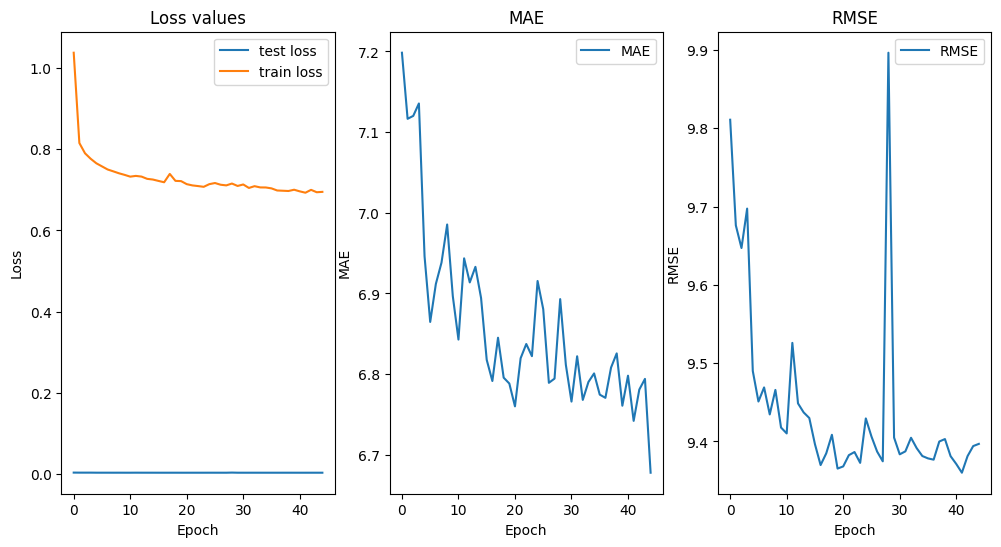

In [ ]:
set_random_seed(137)

train_losses, test_losses, mae, rmse = train(model, optimizer, criterion, train_loader, test_loader, standardScaler)

test_losses_np = np.array(test_losses)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(test_losses, label='test loss')
plt.plot(train_losses, label='train loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss values')

plt.subplot(1, 3, 2)
plt.plot(mae, label='MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE')

plt.subplot(1, 3, 3)
plt.plot(rmse, label='RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE')

plt.show()